In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

from featureio import FeatureIO 
from calzone import Calzone

from collections import Counter, defaultdict
from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf

from pineappleflow.core import experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2022, 1, 18, 0, 0))

from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader, ExperimentLoader

STATISTICAL TESTS: The most common metric functions have been moved to Pineappleflow. Please import by 'from pineappleflow.core.statistics_utils'. Currently includes: SensAndSpecMetrics, get_sens_and_spec, specificity_threshold_interpolated, specificity_thresholds


In [76]:
# functions to get predictions out of two step model

# classes in order of the multinomial classifier
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Colorectal Pre-Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]

CLASSES_IN_ORDER = np.array(["Colorectal Cancer",
           "Breast Cancer",
                "Pancreatic Cancer",
                "Prostate Cancer",
                "Uterine Cancer",
                "Lung Cancer",
                "Esophageal Cancer",
                "Liver Cancer",
                "Ovarian Cancer"])
                
def get_predictions(bucket, path):
    loader = ExperimentLoader(bucket,path)
    df_folds = []
    for fold_name in loader.fold_names():
        fold = loader.fold(fold_name)
        test_dsids = fold.pre_transformer_fold_holder.test.sample_ids
        test_cancer_types = [m.cancer_type for m in fold.pre_transformer_fold_holder.test.sample_metadata]
        #model_recipe = fold.fitted_model_recipe
        #test_class_probs = model_recipe.class_probs
        #classes = [CLASSES[i] for i in fold.fitted_model.classes_]
        
        #Step1HMFC, Step2probCRC, Step2probBRC, Step2probPANC, etc.
        test_class_probs = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        df = pd.DataFrame(test_class_probs)
        df["cancer_type"] = test_cancer_types
        df["dsid"] = test_dsids
        df_folds.append(df)
                        
    df_folds = pd.concat(df_folds)
    df_folds = pd.DataFrame(df_folds.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    y = df_folds["cancer_type"].values
    df_folds = df_folds.drop("cancer_type", axis=1)
    df_folds = df_folds.set_index("dsid")
    print(df_folds.head())
    
    #comine scores after fold score averaging
    healthies = [ct in HEALTHY_TYPES for ct in y]
    step1_thresh = np.percentile(df_folds.iloc[healthies,0].values, 90)
    y_pred = []
    for i,row in df_folds.iterrows():
        # print(row)
        # print(CLASSES_IN_ORDER[np.argmax(row[1:])])
        if row[0] < step1_thresh:
            y_pred.append("Healthy")
        else:
            y_pred.append(CLASSES_IN_ORDER[np.argmax(row[1:])]) 
    
    return y, y_pred, df_folds


def get_sensitivities(y, y_pred, title):
    print(Counter(y_pred))
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(y):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l==i for l in y]
        y_pred_subset = np.array(y_pred)[subset] #cancers
        n_tp = np.sum([call=="Colorectal Cancer" for call in y_pred_subset]) # numer of cancer type id'd as cancer
        if i != "Colorectal Cancer" and i != "Colorectal Pre-Cancer":
            non_crcs += np.sum(subset) #number of cancer type
            sum_tps += n_tp
        call_rates.append(n_tp/float(np.sum(subset)))
    
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(title)
    plt.xticks(CANCER_TYPES, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, plot_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    #return dict(zip(df_samples_avg["sample_id"], zip(df_samples_avg["status"], df_samples_avg["score_mean"])))
    return 


def get_confusion_matrix(y, y_pred, title):
    #print(Counter(y))
    print(Counter(y_pred))
    combos = list(zip(y, y_pred))
    #print(y_pred)
    matches = []
    tp_counts = []
    y_true_labels = list(np.unique(y))
    # produce results for CRC and NCC only (exclude healthies)
    skips = HEALTHY_TYPES + ['Pancreatic Pre-Cancer']
    for ct in skips:
        if ct in y_true_labels:
            y_true_labels.remove(ct)
    for i in y_true_labels:
        matrix_row = []
        for j in np.unique(y_pred):
            matrix_row.append(combos.count((i,j)))
            if i==j:
                tp_counts.append(combos.count((i,j)))
        matches.append(matrix_row)
    arr_matches = np.array(matches)
    percents = arr_matches / arr_matches.sum(axis=1, keepdims=True)
    df_matches = pd.DataFrame(arr_matches, columns=np.unique(y_pred),index=y_true_labels)
    df_percents = pd.DataFrame(percents, columns=np.unique(y_pred),index=y_true_labels)
    #print(percents.shape)
    #print(df_matches.shape)
    
    plt.figure()
    ax = sns.heatmap(df_percents, annot=df_matches, cmap="GnBu", fmt='.0f')
    plt.title(f"{title}\n{os.path.basename(path)}", size=12)
    ax.set_xlabel("Predicted Label", size=14)
    ax.set_ylabel("True Label", size=14)
    print(f"Overall accuracy: {float(np.sum(tp_counts)) / df_matches.sum().sum()}")
    
    return #df_matches

In [77]:
# run misko's pairwise HMFC ensemble through a multinomial regression.
bucket = "freenome-user-data-bgould"
#path = "Multi_cancer/Two_step_models/ensemble/outlier_chmfc_paired_outlier_multinomial_vp2"
path = "Multi_cancer/Two_step_models/ensemble/outlier_chmfc_paired_outlier_multinomial_noHPO_vp2"

y, y_pred, df_folds = get_predictions(bucket, path)

METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
META

             0         1         2         3         4         5         6  \
dsid                                                                         
4943  0.000005  0.265555  0.076767  0.129648  0.098862  0.085763  0.105786   
4953  0.000027  0.270372  0.076224  0.130825  0.097949  0.085087  0.105841   
4957  0.000000  0.269373  0.076279  0.131025  0.098273  0.085328  0.105888   
4991  0.000009  0.271282  0.074892  0.131998  0.100075  0.085269  0.103388   
5006  0.000014  0.269536  0.076725  0.131001  0.099257  0.085362  0.104906   

             7         8         9  
dsid                                
4943  0.090641  0.062168  0.083172  
4953  0.090623  0.061682  0.081829  
4957  0.090647  0.061596  0.081935  
4991  0.091913  0.060965  0.081395  
5006  0.091741  0.061912  0.081911  


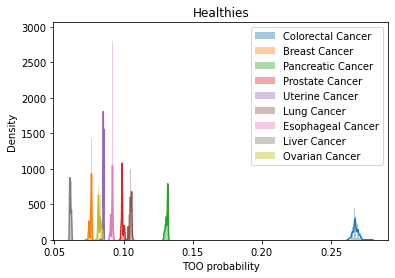

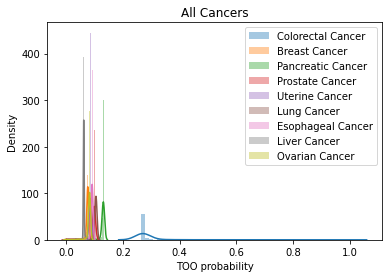

In [78]:
# healthy samples
plt.figure()
for i, row in df_folds.T.iloc[1:,[l in HEALTHY_TYPES for l in y]].iterrows():
    sns.distplot(row, label=CLASSES_IN_ORDER[i-1])
plt.xlabel("TOO probability")
plt.title("Healthies")
plt.legend()

# cancer samples
plt.figure()
for i, row in df_folds.T.iloc[1:,[l not in HEALTHY_TYPES for l in y]].iterrows():
    sns.distplot(row, label=CLASSES_IN_ORDER[i-1])
plt.xlabel("TOO probability")
plt.title("All Cancers")
plt.legend()

Counter({'Healthy': 634, 'Colorectal Cancer': 452})
CRC Sens: 0.9492753623188406
Other Cancer Sens: 0.5932584269662922


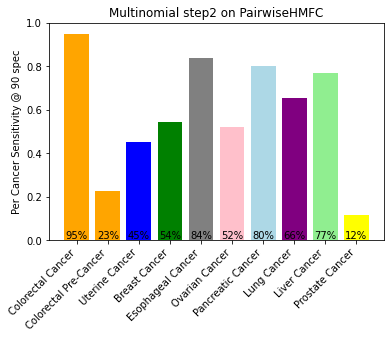

In [79]:
get_sensitivities(y, y_pred, "Multinomial step2 on PairwiseHMFC")

Counter({'Healthy': 634, 'Colorectal Cancer': 452})
Overall accuracy: 0.20727848101265822


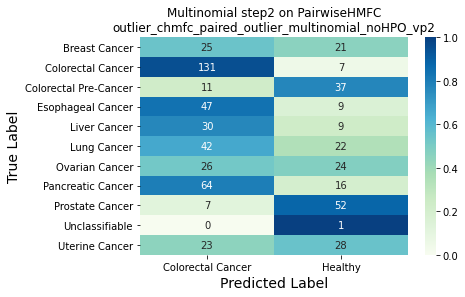

In [80]:
get_confusion_matrix(y, y_pred, "Multinomial step2 on PairwiseHMFC")

In [59]:
def get_predictions2(bucket, path):
    loader = ExperimentLoader(bucket,path)
    df_folds = []
    for fold_name in loader.fold_names():
        fold = loader.fold(fold_name)
        test_dsids = fold.pre_transformer_fold_holder.test.sample_ids
        test_cancer_types = [m.cancer_type for m in fold.pre_transformer_fold_holder.test.sample_metadata]
        #model_recipe = fold.fitted_model_recipe
        #test_class_probs = model_recipe.class_probs
        #classes = [CLASSES[i] for i in fold.fitted_model.classes_]
        
        #Step1HMFC, Step2probCRC, Step2probNCC
        test_class_probs = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        
        df = pd.DataFrame(test_class_probs)
        df["cancer_type"] = test_cancer_types
        df["dsid"] = test_dsids
        df_folds.append(df)
                        
    df_folds = pd.concat(df_folds)
    df_folds = pd.DataFrame(df_folds.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    y = df_folds["cancer_type"].values
    df_folds = df_folds.drop("cancer_type", axis=1)
    df_folds = df_folds.set_index("dsid")
    print(df_folds.head())
    
    #comine scores after fold score averaging
    healthies = [ct in HEALTHY_TYPES for ct in y]
    step1_thresh = np.percentile(df_folds.iloc[healthies,0].values, 90)
    y_pred = []
    for i,row in df_folds.iterrows():
        # print(row)
        # print(CLASSES_IN_ORDER[np.argmax(row[1:])])
        if row[0] < step1_thresh:
            y_pred.append("Healthy")
        else:
            y_pred.append(np.array(["Colorectal Cancer", "NCC"])[np.argmax(row[1:])]) 
    
    return y, y_pred, df_folds

# run misko's pairwise HMFC ensemble through a binomial regression.
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/ensemble/outlier_chmfc_paired_outlier_binarylr_vp2"

y, y_pred, df_folds = get_predictions2(bucket, path) 

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following:

             0         1         2
dsid                              
4943  0.000005  0.293106  0.706894
4953  0.000027  0.108644  0.891356
4957  0.000000  0.238454  0.761546
4991  0.000009  0.196623  0.803377
5006  0.000014  0.459186  0.540814


CRC Sens: 0.5579710144927537
Other Cancer Sens: 0.029213483146067417


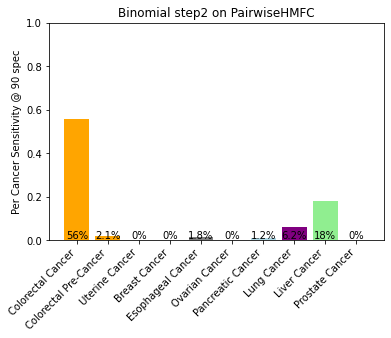

In [61]:
def get_sensitivities2(y, y_pred, title):
    print(Counter(y_pred))
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(y):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l==i for l in y]
        y_pred_subset = np.array(y_pred)[subset] #cancers
        n_tp = np.sum([call!="Healthy" and call!="NCC" for call in y_pred_subset]) # numer of cancer type id'd as cancer
        if i != "Colorectal Cancer" and i != "Colorectal Pre-Cancer":
            non_crcs += np.sum(subset) #number of cancer type
            sum_tps += n_tp
        call_rates.append(n_tp/float(np.sum(subset)))
    
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(title)
    plt.xticks(CANCER_TYPES, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, plot_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    #return dict(zip(df_samples_avg["sample_id"], zip(df_samples_avg["status"], df_samples_avg["score_mean"])))
    return 

get_sensitivities2(y, y_pred, "Binomial step2 on PairwiseHMFC")

Counter({'Healthy': 634, 'NCC': 361, 'Colorectal Cancer': 91})
Overall accuracy: 0.12183544303797468


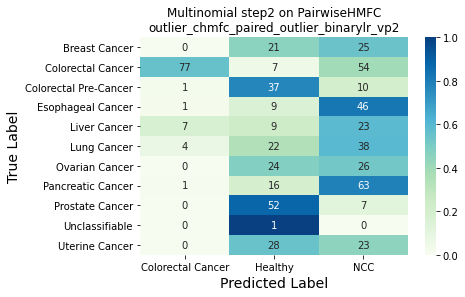

In [62]:



get_confusion_matrix(y, y_pred, "Multinomial step2 on PairwiseHMFC")

In [73]:
def get_predictions3(bucket, path):
    loader = ExperimentLoader(bucket,path)
    df_folds = []
    for fold_name in loader.fold_names():
        fold = loader.fold(fold_name)
        test_dsids = fold.pre_transformer_fold_holder.test.sample_ids
        test_cancer_types = [m.cancer_type for m in fold.pre_transformer_fold_holder.test.sample_metadata]
        #model_recipe = fold.fitted_model_recipe
        #test_class_probs = model_recipe.class_probs
        #classes = [CLASSES[i] for i in fold.fitted_model.classes_]
        
        # Step1prob0, Step1prob1, Step2probCRC, Step2probNCC
        test_class_probs = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        
        df = pd.DataFrame(test_class_probs)
        df["cancer_type"] = test_cancer_types
        df["dsid"] = test_dsids
        df_folds.append(df)
                        
    df_folds = pd.concat(df_folds)
    df_folds = pd.DataFrame(df_folds.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    y = df_folds["cancer_type"].values
    df_folds = df_folds.drop("cancer_type", axis=1)
    df_folds = df_folds.set_index("dsid")
    print(df_folds.head())
    
    #comine scores after fold score averaging
    healthies = [ct in HEALTHY_TYPES for ct in y]
    step1_thresh = np.percentile(df_folds.iloc[healthies,1].values, 90)
    y_pred = []
    for i,row in df_folds.iterrows():
        # print(row)
        # print(CLASSES_IN_ORDER[np.argmax(row[1:])])
        if row[1] < step1_thresh:
            y_pred.append("Healthy")
        else:
            y_pred.append(np.array(["Colorectal Cancer", "NCC"])[np.argmax(row[2:])]) 
    
    return y, y_pred, df_folds




# tunable form of pairwiseHMFC two-step binomial. alpha = 1.0
path = "Multi_cancer/Two_step_models/ensemble/outlier_chmfc_paired_outlier_binarylr_vp2_tunable"

y, y_pred, df_folds = get_predictions3(bucket, path)

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following:

             0         1         2         3
dsid                                        
4943  0.768573  0.231427  0.245110  0.754890
4953  0.014372  0.985628  0.262022  0.737978
4957  0.900395  0.099605  0.257784  0.742216
4991  0.339170  0.660830  0.255212  0.744788
5006  0.204778  0.795222  0.258060  0.741940


CRC Sens: 0.18840579710144928
Other Cancer Sens: 0.01348314606741573
Counter({'Healthy': 642, 'NCC': 410, 'Colorectal Cancer': 34})
Overall accuracy: 0.04113924050632911


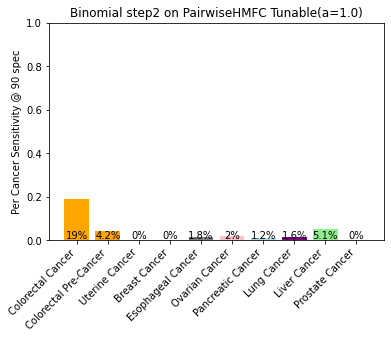

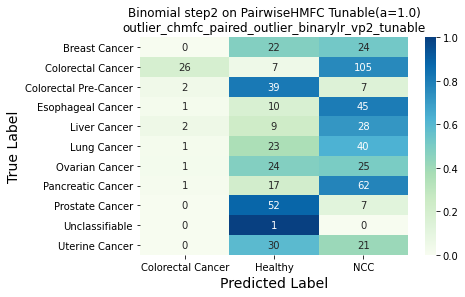

In [74]:
get_sensitivities2(y, y_pred, "Binomial step2 on PairwiseHMFC Tunable(a=1.0)")
get_confusion_matrix(y, y_pred, "Binomial step2 on PairwiseHMFC Tunable(a=1.0)")

In [71]:
# tunable form of pairwiseHMFC two-step binomial. alpha = 0.2
path = "Multi_cancer/Two_step_models/ensemble/outlier_chmfc_paired_outlier_binarylr_vp2_tunable_0pt2_"

y, y_pred, df_folds = get_predictions3(bucket, path)

EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following: `loader.fold('kfold_0').spec.pipeline_yaml`, `loader.fold('kfold_1').spec.pipeline_yaml`, etc.
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
EXPERIMENT LOADER: Warning, single_spec = False so the hyperparameter search returns a best spec PER FOLD. Therefore `loader.spec` is only one of the best specs! To retrieve the best spec per fold do the following:

             0         1         2         3
dsid                                        
4943  0.768573  0.231427  0.255478  0.744522
4953  0.014372  0.985628  0.257878  0.742122
4957  0.900395  0.099605  0.256614  0.743386
4991  0.339170  0.660830  0.253973  0.746027
5006  0.204778  0.795222  0.256578  0.743422


CRC Sens: 0.18840579710144928
Other Cancer Sens: 0.01348314606741573
Counter({'Healthy': 642, 'NCC': 410, 'Colorectal Cancer': 34})
Overall accuracy: 0.04113924050632911


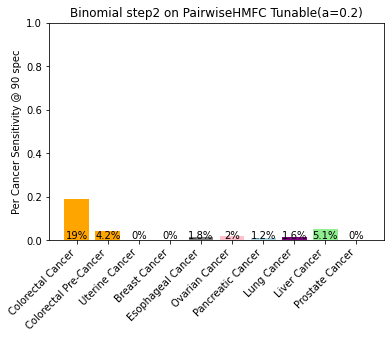

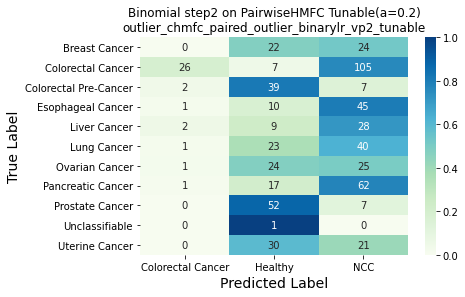

In [75]:
get_sensitivities2(y, y_pred, "Binomial step2 on PairwiseHMFC Tunable(a=0.2)")
get_confusion_matrix(y, y_pred, "Binomial step2 on PairwiseHMFC Tunable(a=0.2)")

METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples


AttributeError: 'MulticlassBinaryClassifier' object has no attribute 'class_probs'

In [ ]:
get_sensitivities(y, y_pred, "Multinomial step2 on PairwiseHMFC Balanced")
get_confusion_matrix(y, y_pred, "Multinomial step2 on PairwiseHMFC Balanced")

In [88]:
# new function for getting TOO out of multinomial model recipe
HEALTHY_TYPES = ["Colorectal Normal / Healthy", "Pancreatic Normal / Healthy", "Normal / Healthy NOS", "Colorectal Benign"]
CANCER_TYPES = ["Colorectal Cancer", "Colorectal Pre-Cancer", "Uterine Cancer", "Breast Cancer", "Esophageal Cancer",
                "Ovarian Cancer", "Pancreatic Cancer", "Lung Cancer", "Liver Cancer", "Prostate Cancer"]
COLORS = ["orange", "orange", "blue", "green", "grey", "pink", "lightblue", "purple", "lightgreen","yellow"]

CLASSES_IN_ORDER = np.array(["Colorectal Cancer",
           "Breast Cancer",
                "Pancreatic Cancer",
                "Prostate Cancer",
                "Uterine Cancer",
                "Lung Cancer",
                "Esophageal Cancer",
                "Liver Cancer",
                "Ovarian Cancer"])
                
def get_predictions_mult(bucket, path):
    '''
    This is TOO model output across all NCC samples, not a two-step TOO output
    '''
    loader = ExperimentLoader(bucket,path)
    df_folds = []
    for fold_name in loader.fold_names():
        fold = loader.fold(fold_name)
        test_dsids = fold.pre_transformer_fold_holder.test.sample_ids
        test_cancer_types = [m.cancer_type for m in fold.pre_transformer_fold_holder.test.sample_metadata]
        X = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        model_recipe = fold.fitted_model
        test_class_probs = model_recipe.predict_proba(X)
        #classes = [CLASSES[i] for i in fold.fitted_model.classes_]
        #test_class_probs = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        df = pd.DataFrame(test_class_probs)
        df["cancer_type"] = test_cancer_types
        df["dsid"] = test_dsids
        df_folds.append(df)
                        
    df_folds = pd.concat(df_folds)
    df_folds = pd.DataFrame(df_folds.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    y = df_folds["cancer_type"].values
    df_folds = df_folds.drop("cancer_type", axis=1)
    df_folds = df_folds.set_index("dsid")
    y_pred = df_folds.apply(lambda row: CLASSES_IN_ORDER[np.argmax(row)], axis=1)
    print(df_folds.head()) 
    
    return y, y_pred, df_folds

In [91]:
# multinomial model performance on ensembel ncc/healthy models
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/ensemble/one_vs_rest_outlier_ensemble_plusMLR_vp2"

y, y_pred, df_folds = get_predictions_mult(bucket, path) 


METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
META

             0         1         2         3         4         5         6  \
dsid                                                                         
4943  0.247840  0.096419  0.123793  0.122144  0.105936  0.086070  0.089442   
4953  0.260543  0.090813  0.135245  0.081114  0.093099  0.096815  0.094085   
4957  0.244251  0.096755  0.125285  0.124091  0.106319  0.085652  0.089275   
4991  0.246944  0.099115  0.122404  0.123994  0.105476  0.088223  0.086918   
5006  0.238386  0.099805  0.119913  0.126695  0.104913  0.090642  0.089328   

             7         8  
dsid                      
4943  0.052803  0.073543  
4953  0.062499  0.073332  
4957  0.050082  0.072385  
4991  0.055467  0.079801  
5006  0.055311  0.067098  


Counter({'Colorectal Cancer': 1033, 'Prostate Cancer': 17, 'Lung Cancer': 13, 'Ovarian Cancer': 11, 'Pancreatic Cancer': 2})
Overall accuracy: 0.23771790808240886


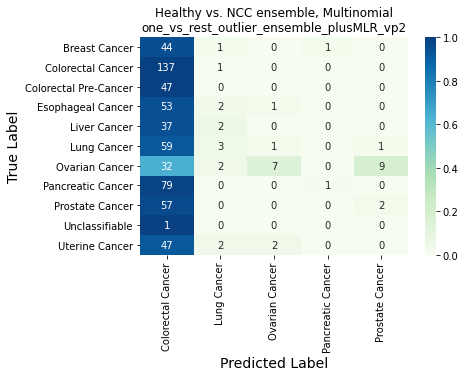

In [92]:
get_confusion_matrix(y, y_pred, "Healthy vs. NCC ensemble, Multinomial")

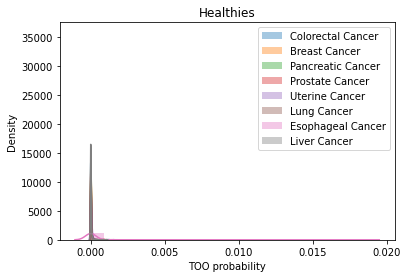

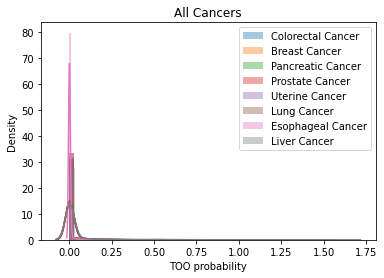

In [40]:
# healthy samples
plt.figure()
for i, row in df_folds.T.iloc[1:,[l in HEALTHY_TYPES for l in y]].iterrows():
    sns.distplot(row, label=CLASSES_IN_ORDER[i-1])
plt.xlabel("TOO probability")
plt.title("Healthies")
plt.legend()

# cancer samples
plt.figure()
for i, row in df_folds.T.iloc[1:,[l not in HEALTHY_TYPES for l in y]].iterrows():
    sns.distplot(row, label=CLASSES_IN_ORDER[i-1])
plt.xlabel("TOO probability")
plt.title("All Cancers")
plt.legend()

In [89]:
# misko ran a class balanced version of NCCvsHealthy ensemble plus MLR
bucket = "freenome-user-data-michaeldzamba"
path = "methyl/2021q4_results/one_vs_rest_outlier_ensemble_plusMLR_vp2_balanced"

y, y_pred, df_folds = get_predictions_mult(bucket, path)

METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
META

             0         1         2         3         4         5         6  \
dsid                                                                         
4943  0.089334  0.130627  0.102358  0.141816  0.132112  0.087074  0.109036   
4953  0.098015  0.132504  0.115262  0.087419  0.114948  0.102892  0.119688   
4957  0.088770  0.127407  0.104712  0.148000  0.132504  0.086723  0.105926   
4991  0.090422  0.143916  0.106686  0.137829  0.134480  0.086396  0.106711   
5006  0.087095  0.143163  0.109067  0.138771  0.135176  0.100749  0.108505   

             7         8  
dsid                      
4943  0.095734  0.105535  
4953  0.109945  0.119150  
4957  0.088124  0.104997  
4991  0.090147  0.107005  
5006  0.094046  0.092595  


Counter({'Prostate Cancer': 543, 'Breast Cancer': 216, 'Uterine Cancer': 113, 'Colorectal Cancer': 55, 'Pancreatic Cancer': 39, 'Esophageal Cancer': 35, 'Liver Cancer': 30, 'Ovarian Cancer': 23, 'Lung Cancer': 22})
Overall accuracy: 0.24881141045958796


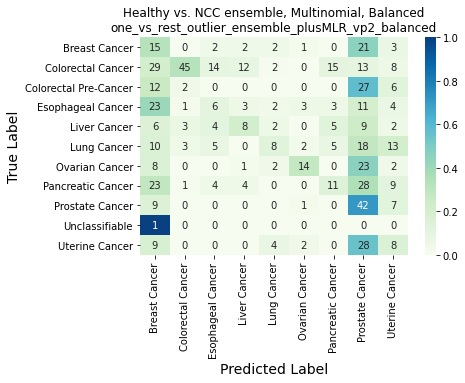

In [90]:
get_confusion_matrix(y, y_pred, "Healthy vs. NCC ensemble, Multinomial, Balanced")

In [108]:
# try the Healthy vs NCC ensembble model in a two-step framework

def get_predictions4(bucket, path):
    loader = ExperimentLoader(bucket,path)
    df_folds_probs = []
    df_folds_hmfc = []
    for fold_name in loader.fold_names():
        fold = loader.fold(fold_name)
        test_dsids = fold.pre_transformer_fold_holder.test.sample_ids
        test_cancer_types = [m.cancer_type for m in fold.pre_transformer_fold_holder.test.sample_metadata]
        X = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        model_recipe = fold.fitted_model
        test_class_probs = model_recipe.predict_proba(X)
        hmfc_scores = X[:,0]
        classes = model_recipe.classes_
        #test_class_probs = fold.post_transformer_fold_holder['mint-chmcfc-VP2-intersect-CpGV2-dsc_v1/v1'].test.x
        df = pd.DataFrame(test_class_probs)
        df["cancer_type"] = test_cancer_types
        df["dsid"] = test_dsids
        df_folds_probs.append(df)
        
        df2 = pd.DataFrame.from_dict({"score":hmfc_scores})
        df2['cancer_type'] = test_cancer_types
        df2['dsid'] = test_dsids
        df_folds_hmfc.append(df2)
                            
    df_folds_probs = pd.concat(df_folds_probs)
    df_folds_probs = pd.DataFrame(df_folds_probs.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    y = df_folds_probs["cancer_type"].values
    df_folds_probs = df_folds_probs.drop("cancer_type", axis=1)
    df_folds_probs = df_folds_probs.set_index("dsid")
    
    df_folds_hmfc = pd.concat(df_folds_hmfc)
    df_folds_hmfc = pd.DataFrame(df_folds_hmfc.groupby(["dsid", "cancer_type"]).agg("median").reset_index())
    df_folds_hmfc = df_folds_hmfc.drop("cancer_type", axis=1)
    df_folds_hmfc = df_folds_hmfc.set_index("dsid")
    
    print(df_folds_probs.head())
    print(df_folds_hmfc.head())
    
    #comine scores after fold score averaging
    healthies = [ct in HEALTHY_TYPES for ct in y]
    step1_thresh = np.percentile(np.array(df_folds_hmfc)[healthies], 90)
    y_pred = []
    for dsid,row in df_folds_hmfc.iterrows():
        # print(row)
        # print(CLASSES_IN_ORDER[np.argmax(row[1:])])
        if row["score"] < step1_thresh:
            y_pred.append("Healthy")
        else:
            y_pred.append(np.array(classes)[np.argmax(df_folds_probs.loc[dsid, :])]) 
    
    print(df_folds_probs.head()) 
    
    return y, y_pred, df_folds_probs
# NCC vs. Healthy ensemble plus binomial LR in two-step framework
bucket = "freenome-user-data-bgould"
path = "Multi_cancer/Two_step_models/ensemble/outlier_plus_one_vs_rest_ensemble_BLR_vp2"

y, y_pred, df_folds_probs = get_predictions4(bucket, path) 

METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
METADATA BALANCED KFOLD: Missing metadata attribute "['cancer_type']" in 0 samples
META

             0         1
dsid                    
4943  0.485115  0.514885
4953  0.482830  0.517170
4957  0.486810  0.513190
4991  0.479302  0.520698
5006  0.482706  0.517294
          score
dsid           
4943   0.527562
4953  13.735552
4957   0.000000
4991   1.787268
5006   0.968624
             0         1
dsid                    
4943  0.485115  0.514885
4953  0.482830  0.517170
4957  0.486810  0.513190
4991  0.479302  0.520698
5006  0.482706  0.517294


Counter({'Healthy': 622, 'NCC': 326, 'Colorectal Cancer': 128})
CRC Sens: 0.6884057971014492
Other Cancer Sens: 0.06741573033707865


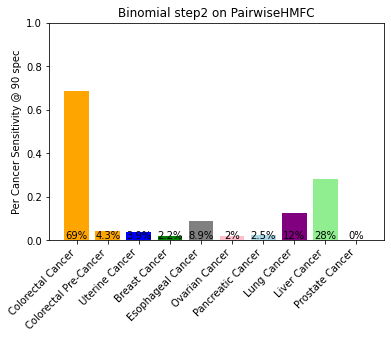

In [109]:
def get_sensitivities3(y, y_pred, title):
    print(Counter(y_pred))
    call_rates = []
    types = []
    skip = ["Pancreatic Pre-Cancer", "Unclassifiable"]
    sum_tps = 0
    non_crcs = 0
    for i in np.unique(y):
        if i in (HEALTHY_TYPES + skip):
            continue
        types.append(i)
        subset = [l==i for l in y]
        y_pred_subset = np.array(y_pred)[subset] #cancers
        n_tp = np.sum([call!="Healthy" and call!="NCC" for call in y_pred_subset]) # numer of cancer type id'd as cancer
        if i != "Colorectal Cancer" and i != "Colorectal Pre-Cancer":
            non_crcs += np.sum(subset) #number of cancer type
            sum_tps += n_tp
        call_rates.append(n_tp/float(np.sum(subset)))
    
    call_rate_dict = dict(zip(types, call_rates))
    plot_rates = []
    for ct in CANCER_TYPES:
        if ct not in call_rate_dict.keys():
            plot_rates.append(np.nan)
        else:
            plot_rates.append(call_rate_dict[ct])
    
    fig, ax = plt.subplots()
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    plt.bar(CANCER_TYPES, plot_rates, color=COLORS )
    plt.ylabel("Per Cancer Sensitivity @ 90 spec")
    plt.ylim([0,1])
    plt.title(title)
    plt.xticks(CANCER_TYPES, rotation=45, ha='right')
    # add bar labels
    for rect, label in zip(ax.patches, plot_rates):
        height = 0
        ax.text(rect.get_x() + rect.get_width() / 2, height, f"{(label*100):.2g}%", ha="center", va="bottom")
    
    crc_sens = call_rates[list(types).index("Colorectal Cancer")]
    print(f"CRC Sens: {crc_sens}")
    print(f"Other Cancer Sens: {sum_tps/float(non_crcs)}")
    #return dict(zip(df_samples_avg["sample_id"], zip(df_samples_avg["status"], df_samples_avg["score_mean"])))
    return 

get_sensitivities3(y, y_pred, "Binomial step2 on NCC vs. Healthy ensemble")

Counter({'Healthy': 622, 'NCC': 326, 'Colorectal Cancer': 128})
Overall accuracy: 0.15055467511885895


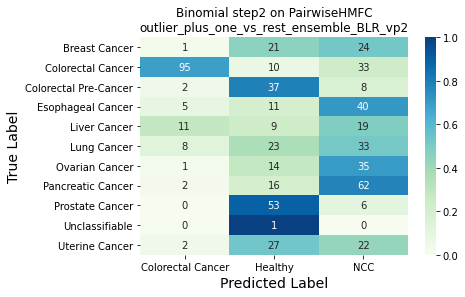

In [110]:
get_confusion_matrix(y, y_pred, title="Binomial step2 on PairwiseHMFC")